# Positioning Redundant Mannipulator Performance 

In [1]:
import robosandbox as rsb
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm
import matplotlib.pyplot as plt
from robosandbox.performance.WorkSpace import WorkSpace
import plotly.express as px
import pandas as pd


## Definition 

The generic manipulator of 4 Dofs is defined in DH description and the actuators' directions from 2 to 4 and EE are defined by alpha list.

In [5]:
%matplotlib qt
robot = rsb.models.DH.Generic.GenericFour(alpha=[np.pi/2, 0, 0, 0])
robot.plot(q=robot.qr)
plt.savefig("fig/robot_redundant.png")

![redundant robot](fig/robot_redundant.png)

## Evaluate Alpha 3&4 Effects on Global Indices

In [5]:
def evaluate_alpha_effect(
    alpha_list3, alpha_list4, isSave=False, method="invcondition", axes="all"
):
    """
    Evaluate the effect of alpha on the global indices.
    """
    results = []
    res_mat = np.zeros((len(alpha_list3), len(alpha_list4)))
    for i, alpha3 in tqdm(
        enumerate(alpha_list3),
        total=len(alpha_list3),
        desc="alpha3 progress",
        unit="outer",
    ):
        for j, alpha4 in tqdm(
            enumerate(alpha_list4),
            total=len(alpha_list4),
            desc=f"alpha4 progress (alpha3={np.rad2deg(alpha3)})",
            unit="inner",
            leave=False,
        ):
            robot = rsb.models.DH.Generic.GenericFour(alpha=[np.pi / 2, alpha3, alpha4, 0])
            ws = WorkSpace(robot=robot)
            G = ws.iter_calc_global_indice(
                    initial_samples=3000,
                    batch_ratio=0.1,
                    error_tolerance_percentage=1e-3,
                    method=method,
                    axes=axes,
                    max_samples=30000,
                )
            results.append([alpha3, alpha4, G])
            res_mat[i, j] = G
            del robot, ws

    results = np.array(results)
    if isSave:
        filename = f"data/two_alpha/{method}_{axes}.npz"
        np.savez(filename, results=results, res_mat=res_mat)
    return results, res_mat


In [6]:
def plot_global_index_results(
    alpha_list_deg3,
    alpha_list_deg4,
    res_mat,
    plot_type="heatmap",
    method="invcondition",
    axes="all",
    isSave=False,
):
    """
    Plot the effect of alpha on the global indices using Plotly.
    """
    G_mat = res_mat
    # print(G_mat)
    fig = go.Figure()
    if plot_type == "heatmap":
        fig = go.Figure(
            data=go.Heatmap(
                z=G_mat,
                x=alpha_list_deg3,
                y=alpha_list_deg4,
                # colorscale='Viridis',
                colorbar=dict(
                    title=f"{method}", titlefont=dict(size=40), tickfont=dict(size=40)
                ),
            )
        )

    if plot_type == "surface":
        fig = go.Figure(
            data=go.Surface(
                z=G_mat,
                x=alpha_list_deg3,
                y=alpha_list_deg4,
                colorbar=dict(
                    title=f"{method}", titlefont=dict(size=40), tickfont=dict(size=40)
                ),
            )
        )
        fig.update_layout(
            scene=dict(
                xaxis_title="alpha3 (deg)",
                yaxis_title="alpha4 (deg)",
                zaxis_title="",
                xaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                yaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                zaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                camera=dict(
                    eye=dict(x=1.55, y=1.55, z=1.55),
                    up=dict(x=0, y=0, z=1),
                ),
            )
        )

    fontsize = 40
    fig.update_layout(
        # title=f'Effect of alpha on global indices using {method} method and {axes} axes',
        xaxis_title="alpha3 (deg)",
        yaxis_title="alpha4 (deg)",
        autosize=True,
        height=800,
        width=1000,
        xaxis_title_font=dict(size=40),  # Font size for x-axis title
        yaxis_title_font=dict(size=40),
        xaxis=dict(tickfont=dict(size=fontsize), dtick=30),
        yaxis=dict(tickfont=dict(size=fontsize), dtick=30),
    )

    if isSave:
        fig.write_image(f"fig/two_alpha/{method}_{axes}_{plot_type}.png")
        fig.write_html(f"fig/two_alpha/{method}_{axes}_{plot_type}.html")
    fig.show()

### Global Indice - Manipulability from Yoshikawa

$$
\sqrt{\det(J(q)J^T(q))}
$$

In [10]:
np.random.seed(42)

# from 0, 10, 20, ..., 180 deg for alpha
alpha_list_deg3 = np.arange(0, 181, 15)
alpha_list_rad3 = np.deg2rad(alpha_list_deg3)
alpha_list_deg4 = np.arange(0, 181, 15)
alpha_list_rad4 = np.deg2rad(alpha_list_deg4)
print(f"alpha 3: {alpha_list_deg3}")
print(f"alpha 4: {alpha_list_deg4}")

method = "yoshikawa"
axes = "all"

# isRun = True
# isSave = True

isSave = False
isRun = False

if isRun:
    res, res_mat = evaluate_alpha_effect(
        alpha_list_rad3, alpha_list_rad4, isSave=True, method=method, axes=axes
    )
if not isRun:
    npzfile = np.load(f"data/two_alpha/{method}_{axes}.npz")
    res = npzfile["results"]
    res_mat = npzfile["res_mat"]
plot_global_index_results(
    alpha_list_deg3,
    alpha_list_deg4,
    res_mat,
    plot_type="surface",
    method=method,
    axes=axes,
    isSave=isSave,
)
plot_global_index_results(
    alpha_list_deg3,
    alpha_list_deg4,
    res_mat,
    plot_type="heatmap",
    method=method,
    axes=axes,
    isSave=isSave,
)

alpha 3: [  0  15  30  45  60  75  90 105 120 135 150 165 180]
alpha 4: [  0  15  30  45  60  75  90 105 120 135 150 165 180]


### Global Indice - Inverse Condition Number
$$\sigma_{\text{min}}/\sigma_{\text{max}}$$

In [9]:
np.random.seed(42)

# from 0, 10, 20, ..., 180 deg for alpha
alpha_list_deg3 = np.arange(0, 181, 15)
alpha_list_rad3 = np.deg2rad(alpha_list_deg3)
alpha_list_deg4 = np.arange(0, 181, 15)
alpha_list_rad4 = np.deg2rad(alpha_list_deg4)
print(f"alpha 3: {alpha_list_deg3}")
print(f"alpha 4: {alpha_list_deg4}")

method = "invcondition"
axes = "all"

# isRun = True
isSave = True

# isSave = False
isRun = False

if isRun:
    res, res_mat = evaluate_alpha_effect(
        alpha_list_rad3, alpha_list_rad4, isSave=True, method=method, axes=axes
    )
if not isRun:
    npzfile = np.load(f"data/two_alpha/{method}_{axes}.npz")
    res = npzfile["results"]
    res_mat = npzfile["res_mat"]


plot_global_index_results(
    alpha_list_deg3,
    alpha_list_deg4,
    res_mat,
    plot_type="surface",
    method=method,
    axes=axes,
    isSave=isSave,
)

plot_global_index_results(
    alpha_list_deg3,
    alpha_list_deg4,
    res_mat,
    plot_type="heatmap",
    method=method,
    axes=axes,
    isSave=isSave,
)

alpha 3: [  0  15  30  45  60  75  90 105 120 135 150 165 180]
alpha 4: [  0  15  30  45  60  75  90 105 120 135 150 165 180]


### Global Indice - Minimum Singular Value
$$
\sigma_{\text{min}}
$$

In [14]:
np.random.seed(42)

# from 0, 10, 20, ..., 180 deg for alpha
alpha_list_deg3 = np.arange(0, 181, 15)
alpha_list_rad3 = np.deg2rad(alpha_list_deg3)
alpha_list_deg4 = np.arange(0, 181, 15)
alpha_list_rad4 = np.deg2rad(alpha_list_deg4)
print(f"alpha 3: {alpha_list_deg3}")
print(f"alpha 4: {alpha_list_deg4}")

method = "minsingular"
axes = "all"

# isRun = True
# isSave = True

isSave = False
isRun = False

if isRun:
    res, res_mat = evaluate_alpha_effect(
        alpha_list_rad3, alpha_list_rad4, isSave=True, method=method, axes=axes
    )
if not isRun:
    npzfile = np.load(f"data/two_alpha/{method}_{axes}.npz")
    res = npzfile["results"]
    res_mat = npzfile["res_mat"]


plot_global_index_results(
    alpha_list_deg3,
    alpha_list_deg4,
    res_mat,
    plot_type="surface",
    method=method,
    axes=axes,
    isSave=isSave,
)

plot_global_index_results(
    alpha_list_deg3,
    alpha_list_deg4,
    res_mat,
    plot_type="heatmap",
    method=method,
    axes=axes,
    isSave=isSave,
)

alpha 3: [  0  15  30  45  60  75  90 105 120 135 150 165 180]
alpha 4: [  0  15  30  45  60  75  90 105 120 135 150 165 180]


## Evaluate Alpha 2&3&4 Effects on Global Indices

In [45]:
def evaluate_3alpha_effect(
    alpha_list2, alpha_list3, alpha_list4, isSave=False, method="invcondition", axes="all"
):
    """
    Evaluate the effect of alpha on the global indices.
    """
    results = []
    res_mat = np.zeros((len(alpha_list2), len(alpha_list3), len(alpha_list4)))
    for i, alpha2 in tqdm(
        enumerate(alpha_list2),
        total=len(alpha_list2),
        desc="alpha2 progress",
        unit="outer",
    ):
        for j, alpha3 in tqdm(
            enumerate(alpha_list3),
            total=len(alpha_list3),
            desc=f"alpha3 progress (alpha2={np.rad2deg(alpha2)})",
            unit="inner",
            leave=False,
        ):
            for k, alpha4 in tqdm(
                enumerate(alpha_list4),
                total=len(alpha_list4),
                desc=f"alpha4 progress (alpha2={np.rad2deg(alpha2)}, alpha3={np.rad2deg(alpha3)})",
                unit="inner",
                leave=False,
            ):
                robot = rsb.models.DH.Generic.GenericFour(alpha=[alpha2, alpha3, alpha4, 0])
                ws = WorkSpace(robot=robot)
                G = ws.iter_calc_global_indice(
                    initial_samples=3000,
                    batch_ratio=0.1,
                    error_tolerance_percentage=1e-3,
                    method=method,
                    axes=axes,
                    max_samples=30000,
                )
                results.append([alpha2, alpha3, alpha4, G])
                res_mat[i, j, k] = G
                del robot, ws

    results = np.array(results)
    if isSave:
        filename = f"data/three_alpha/{method}_{axes}.npz"
        np.savez(filename, results=results, res_mat=res_mat)
    return results, res_mat


def plot_scatter_global_index_results(
    alpha_list_deg2,
    alpha_list_deg3,
    alpha_list_deg4,
    res,
    res_mat,
    plot_type="scatter",
    method="invcondition",
    axes="all",
    isSave=False,
):
    G_mat= res[:,-1].copy()
    if plot_type == "scatter":
        fig = go.Figure(
            data=go.Scatter3d(
                x=np.rad2deg(res[:, 0]),
                y=np.rad2deg(res[:, 1]),
                z=np.rad2deg(res[:, 2]),
                mode="markers",
                marker=dict(
                    size=10,
                    color=G_mat,
                    # colorscale="Viridis",
                    colorbar=dict(title=f"{method}", titlefont=dict(size=40), tickfont=dict(size=40)),
                ),
            )
        )
        fig.update_layout(
            scene=dict(
                xaxis_title="alpha2 (deg)",
                yaxis_title="alpha3 (deg)",
                zaxis_title="alpha4 (deg)",
                xaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                yaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                zaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                camera=dict(
                    eye=dict(x=1.55, y=1.55, z=1.55),
                    up=dict(x=0, y=0, z=1),
                ),
            )
        )

    if plot_type == 'parallel': 
        # Convert the data to a DataFrame
        columns = ['alpha2', 'alpha3', 'alpha4', 'G']
        res[:,:3] = np.rad2deg(res[:,:3])
        df = pd.DataFrame(res, columns=columns)
        fig = px.parallel_coordinates(
            df, color='G',
            labels={'0': 'alpha2 (deg)', '1': 'alpha3 (deg)', '2': 'alpha4 (deg)'},
            # color_continuous_scale='Viridis',
            height=800,
            width=1000,
        )
    if plot_type == "surface":
        print("PLotting Surface")
        fig = go.Figure(
            data=go.Surface(
                x=res[:, 0],
                y=res[:, 1],
                z=res[:, 2],
                surfacecolor=res_mat,
            )
        )
        fig.update_layout(
            scene=dict(
                xaxis_title="alpha2 (deg)",
                yaxis_title="alpha3 (deg)",
                zaxis_title="alpha4 (deg)",
                xaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                yaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                zaxis=dict(titlefont=dict(size=40), tickfont=dict(size=16), dtick=90),
                camera=dict(
                    eye=dict(x=1.55, y=1.55, z=1.55),
                    up=dict(x=0, y=0, z=1),
                ),
            )
        )
        
    # df = px.data.iris()
    # fig = px.scatter_3d(
    #     x=res[:, 0],
    #     y=res[:, 1],
    #     z=res[:, 2],
    #     color=G_mat,
    #     title=f'Effect of alpha on global indices using {method} method and {axes} axes',
    #     labels={'x': 'alpha2 (deg)', 'y': 'alpha3 (deg)', 'z': 'alpha4 (deg)'},
    #     color_continuous_scale='Viridis',
    #     height=800,
    #     width=1000,
    # )
    if isSave:
        fig.write_image(f"fig/three_alpha/{method}_{axes}_{plot_type}.png")
        fig.write_html(f"fig/three_alpha/{method}_{axes}_{plot_type}.html")
    fig.show()

    

### Global Indice - Inverse Condition Number

In [46]:
np.random.seed(42)

# from 0, 10, 20, ..., 180 deg for alpha
alpha_list_deg2 = np.arange(-90, 91, 15)
alpha_list_rad2 = np.deg2rad(alpha_list_deg2)
alpha_list_deg3 = np.arange(-90, 91, 15)
alpha_list_rad3 = np.deg2rad(alpha_list_deg3)
alpha_list_deg4 = np.arange(-90, 91, 15)
alpha_list_rad4 = np.deg2rad(alpha_list_deg4)
print(f"alpha 2: {alpha_list_deg2}")
print(f"alpha 3: {alpha_list_deg3}")
print(f"alpha 4: {alpha_list_deg4}")

method = "invcondition"
axes = "all"

isRun = True
isSave = True

isSave = False
isRun = False

if isRun:
    res, res_mat = evaluate_3alpha_effect(
        alpha_list_rad2, alpha_list_rad3, alpha_list_rad3, isSave=True, method=method, axes=axes
    )
if not isRun:
    npzfile = np.load(f"data/three_alpha/{method}_{axes}.npz")
    res = npzfile["results"]
    res_mat = npzfile["res_mat"]

plot_scatter_global_index_results(
    alpha_list_deg2,
    alpha_list_deg3,
    alpha_list_deg4,
    res,
    res_mat,
    plot_type="parallel",
    method=method,
    axes=axes,
    isSave=isSave,
)


alpha 2: [-90 -75 -60 -45 -30 -15   0  15  30  45  60  75  90]
alpha 3: [-90 -75 -60 -45 -30 -15   0  15  30  45  60  75  90]
alpha 4: [-90 -75 -60 -45 -30 -15   0  15  30  45  60  75  90]


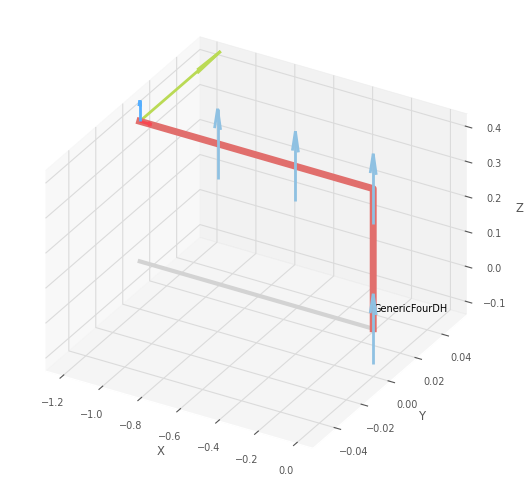

0.0

<Figure size 640x480 with 0 Axes>

In [38]:
robot_g = rsb.models.DH.Generic.GenericFour(alpha=[np.deg2rad(0), 0, np.deg2rad(0), 0])
robot_g.plot(q=robot_g.qz)
robot_g.manipulability(q=[0.1, 0.2, 0.3, 0.4], method='minsingular')

## Optimization Actuators Directions

### Method 1: Numerical Optimization with Initial Guess and Evaluated Objective

In [1]:
from scipy.optimize import minimize

In [2]:
def objective_global_indice(alpha2, alpha3, alpha4, method):
    robot = rsb.models.DH.Generic.GenericFour(alpha=[alpha2, alpha3, alpha4, 0])
    ws = WorkSpace(robot=robot)
    G = ws.iter_calc_global_indice(
        initial_samples=3000,
        batch_ratio=0.1,
        error_tolerance_percentage=1e-3,
        method=method,
        axes="all",
        max_samples=30000,
    )
    return G

#### Inverse Condition Number

In [18]:
# Conversion from degrees to radians for alpha bounds
lb = np.deg2rad(0)  # Lower bound in radians
ub = np.deg2rad(90)   # Upper bound in radians

# Define the bounds and initial guess for the optimization
initial_guess = [(lb + ub) / 2, (lb + ub) / 2, (lb + ub) / 2]  # Midpoint for the initial guess

# Define the bounds as a list of tuples (lower, upper)
bounds = [(lb, ub), (lb, ub), (lb, ub)]

# Objective function for scipy.optimize (must return a scalar)
def obj_func(x):
    alpha2, alpha3, alpha4 = x
    return -objective_global_indice(alpha2, alpha3, alpha4, method='invcondition')

options = {
    'maxiter': 1000,  # Maximum number of iterations
    'disp': True
}

# Perform the optimization using scipy.optimize.minimize
result = minimize(obj_func, [np.pi/4, 0, np.pi/8], bounds=bounds, method='SLSQP', options=options)

# Print the results
if result.success:
    print("Optimization successful!")
    print("Optimal values for alpha2, alpha3, and alpha4:", result.x)
    print("Optimal value of the objective function:", result.fun)
else:
    print("Optimization failed:", result.message)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.045999976915749634
            Iterations: 8
            Function evaluations: 111
            Gradient evaluations: 8
Optimization successful!
Optimal values for alpha2, alpha3, and alpha4: [0.78178948 0.00520282 0.39277184]
Optimal value of the objective function: -0.045999976915749634


In [19]:
print("Optimal values for alpha2, alpha3, and alpha4:", np.rad2deg(np.round(result.x, 2)))

Optimal values for alpha2, alpha3, and alpha4: [44.69070802  0.5729578  22.34535401]


In [50]:
robot_optimized = rsb.models.DH.Generic.GenericFour(alpha=[result.x[0], result.x[1], result.x[2], 0])
robot_optimized = rsb.models.DH.Generic.GenericFour(alpha=[0.0001, 0.001, 0.01417424, 0])
ws = WorkSpace(robot=robot_optimized)
G = ws.iter_calc_global_indice(
    initial_samples=3000,
    batch_ratio=0.1,
    error_tolerance_percentage=1e-3,
    method='invcondition',
    axes="all",
    max_samples=30000,
)
%matplotlib qt
robot_optimized.plot(q=robot_optimized.qz)
print(f"Global index for the optimized robot: {G}")

Global index for the optimized robot: 0.10079386343042675


#### Yoshikawa Manipulability

In [ ]:
# Conversion from degrees to radians for alpha bounds
lb = np.deg2rad(0)  # Lower bound in radians
ub = np.deg2rad(90)   # Upper bound in radians

# Define the bounds and initial guess for the optimization
initial_guess = [(lb + ub) / 2, (lb + ub) / 2, (lb + ub) / 2]  # Midpoint for the initial guess

# Define the bounds as a list of tuples (lower, upper)
bounds = [(lb, ub), (lb, ub), (lb, ub)]

# Objective function for scipy.optimize (must return a scalar)
def obj_func(x):
    alpha2, alpha3, alpha4 = x
    return -objective_global_indice(alpha2, alpha3, alpha4, method='yoshikawa')

# Perform the optimization using scipy.optimize.minimize
result = minimize(obj_func, [np.pi/2, 0, 0], bounds=bounds, method='Powell')

# Print the results
if result.success:
    print("Optimization successful!")
    print("Optimal values for alpha2, alpha3, and alpha4:", result.x)
    print("Optimal value of the objective function:", result.fun)
else:
    print("Optimization failed:", result.message)

NameError: name 'minimize' is not defined

In [52]:
print("Optimal values for alpha2, alpha3, and alpha4:", np.rad2deg(np.round(result.x, 2)))

Optimal values for alpha2, alpha3, and alpha4: [64.74423085 30.36676314 31.51267873]


In [53]:
robot_optimized = rsb.models.DH.Generic.GenericFour(alpha=[result.x[0], result.x[1], result.x[2], 0])
ws = WorkSpace(robot=robot_optimized)
G = ws.iter_calc_global_indice(
    initial_samples=3000,
    batch_ratio=0.1,
    error_tolerance_percentage=1e-3,
    method='invcondition',
    axes="all",
    max_samples=30000,
)
%matplotlib qt
robot_optimized.plot(q=robot_optimized.qz)
print(f"Global index for the optimized robot: {G}")

Global index for the optimized robot: 0.03137096541753697


### Genetic Algorithms (GA)

In [4]:
from scipy.optimize import differential_evolution

# Define the bounds for the optimization (same as before)
bounds = [(-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2)]

# Define the objective function for optimization
def obj_func(params):
    alpha2, alpha3, alpha4 = params
    return -objective_global_indice(alpha2, alpha3, alpha4, method='invcondition')

# Perform differential evolution (GA)
result = differential_evolution(obj_func, bounds, maxiter=1000, disp=True)

# Print the results
print("Optimal values for alpha2, alpha3, and alpha4:", result.x)
print("Optimal value of the objective function:", result.fun)


differential_evolution step 1: f(x)= -0.0723151
differential_evolution step 2: f(x)= -0.0871547
differential_evolution step 3: f(x)= -0.0871547
differential_evolution step 4: f(x)= -0.0954496
differential_evolution step 5: f(x)= -0.0954496
differential_evolution step 6: f(x)= -0.0990264
differential_evolution step 7: f(x)= -0.100568
differential_evolution step 8: f(x)= -0.100568
differential_evolution step 9: f(x)= -0.100655
differential_evolution step 10: f(x)= -0.100655
differential_evolution step 11: f(x)= -0.101615
differential_evolution step 12: f(x)= -0.102019
differential_evolution step 13: f(x)= -0.102019
differential_evolution step 14: f(x)= -0.10204
differential_evolution step 15: f(x)= -0.10204
differential_evolution step 16: f(x)= -0.102399
Polishing solution with 'L-BFGS-B'
Optimal values for alpha2, alpha3, and alpha4: [0.00153755 0.08534954 0.08967023]
Optimal value of the objective function: -0.10239880406801362


In [11]:
# # Define decision variables (symbolic variables)
# alpha2 = ca.MX.sym('alpha2')  # Variable alpha2
# alpha3 = ca.MX.sym('alpha3')  # Variable alpha3
# alpha4 = ca.MX.sym('alpha4')  # Variable alpha4

# obj = objective_Global_indice(alpha2, alpha3, alpha4, method='invcondition')

# # Conversion from degrees to radians for alpha bounds
# lb = np.deg2rad(-90)  # Lower bound in radians
# ub = np.deg2rad(90)   # Upper bound in radians


# # Collect variables into a vector
# x = ca.vertcat(alpha2, alpha3, alpha4)

# # Define the constraints for the variables
# c1 = alpha2 - lb  # alpha2 >= lb
# c2 = ub - alpha2  # alpha2 <= ub
# c3 = alpha3 - lb  # alpha3 >= lb
# c4 = ub - alpha3  # alpha3 <= ub
# c5 = alpha4 - lb  # alpha4 >= lb
# c6 = ub - alpha4  # alpha4 <= ub

# # Collect the constraints into a single vector (all inequality constraints)
# constraints = ca.vertcat(c1, c2, c3, c4, c5, c6)

# # Create a CasADi NLP problem
# nlp = {
#     'x': x,
#     'f': obj,
#     'g': constraints  # Inequality constraints
# }

# # Solver options
# opts = {'ipopt.print_level': 0, 'print_time': 0}
# solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

# # Solve the optimization problem
# # Initial guess for the variables (e.g., set to middle of bounds)
# alpha2_init = (lb + ub) / 2
# alpha3_init = (lb + ub) / 2
# alpha4_init = (lb + ub) / 2

# # Collect the initial guess into a vector
# initial_guess = np.array([alpha2_init, alpha3_init, alpha4_init])

# sol = solver(x0=initial_guess)

# # Extract the optimal solution
# optimal_x = sol['x']
# optimal_value = sol['f']

# # Print the results
# print('Optimal values for alpha2, alpha3, and alpha4: ')
# print(optimal_x)
# print('Optimal value of the objective function: ')
# print(optimal_value)



RuntimeError: .../casadi/core/mx_node.cpp:203: Can only determine truth value of a numeric MX.